In [1]:
import pandas as pd
import numpy as np
import datetime
import pickle
import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dropout, BatchNormalization, Activation
from keras.models import Model
import tensorflow
import matplotlib.pyplot as plt
from keras.models import load_model

2023-03-08 23:55:32.731157: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 23:55:33.773763: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /hpc/mp/spack/opt/spack/linux-ubuntu20.04-zen2/gcc-10.3.0/cudnn-8.2.4.15-11.4-eluwegpwn6adr7hlku5p5wru5xzefpop/lib64:/hpc/mp/spack/opt/spack/linux-ubuntu20.04-zen2/gcc-10.3.0/cuda-11.4.4-ctldo35wmmwws3jbgwkgjjcjawddu3qz/lib64:/hpc/mp/spack/opt/spack/linux-ubuntu20.04-zen2/gcc-10.3.0/neovim-0.7.0-terkir3wk5rst6ktv4uxyaqjditacv5p/lib
2023-03-08 23:55:33.773837: W tensorflow/compiler/xla/stream_execut

In [2]:
# make tensorlfow work better with gpus:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

# eager execution:
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)

# Overview of Dataset

What is the classification task and what is the format of the feature data. Is this multi-task, multi-modal, or both? Explain.
Who collected the data? Why? When?
What evaluation criteria will you be using and why? 

https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/

We are using the IMDB-Wiki dataset for multi-task learning of Age and Gender from facial image data. We will be doing multi-task by training a model to classify geneder and regress age of a certain person based on their picture. The images in this dataset are preprocessed so that they are cropped to the persons face.


This data was collecteted by crawling through Wikipedia celebrity profile pages and extracting their Age and Gender as well as their profile image. The images that did not have a timestamp were removed. The data was extracted to provide a dataset for age prediction.


We will be evaluating our gender prediction task with Accuracy and AUC score. We will evaluate the age regression model with mean absolute error. 


# Tasks

This dataset has two target tasks, predicting the age and gender of a person given their image. Both tasks are within the same domain of identifying features of a person based on their image.

In [3]:
# CONSTANTS

DATA_DIR = "/work/users/skoka/Data/wiki_crop/"
META_DATA =  "/work/users/skoka/Data/wiki_crop/wiki.mat"

PICKLES_PATH = "/work/users/skoka/Data/wiki_crop_pickles/"
GET_IMAGES_FROM_PICKLE = True

In [4]:
# extract data from a .mat file
import scipy.io as sio


mat = sio.loadmat(META_DATA)
# convert the data to a pandas dataframe
mat_data = mat['wiki'][0][0]

# 0 -> Matlab datatime format
# 1 -> Years
# 2 -> Path to image
# 3 -> Gender

# convert Matlab serial date number to datetime object
def matlab_to_datetime(matlab_serial_date):
    python_datetime = datetime.datetime.fromordinal(int(matlab_serial_date)) + \
                      datetime.timedelta(days=matlab_serial_date % 1) - \
                      datetime.timedelta(days=366)
    return python_datetime

def get_age(born_matlab_date, current_year):
    return current_year - matlab_to_datetime(born_matlab_date).year

new_data = [
    # {
        # image_path, gender, age
    # }
]

for i in range(len(mat_data[0][0])):
    new_data.append({
        "image_path": mat_data[2][0][i][0],
        "age": get_age(int(mat_data[0][0][i]), mat_data[1][0][i]),
        "gender": mat_data[3][0][i]
    })

df = pd.DataFrame(new_data)

In [5]:
# reading in images:
from PIL import Image
import os

def read_image(path):
    image = Image.open(os.path.join(DATA_DIR, path))
    image = image.resize((256, 256))
    return np.array(image)

if not GET_IMAGES_FROM_PICKLE:
    list_of_images = []
    for i in range(len(df)):
        list_of_images.append(read_image(df["image_path"][i]))
    with open(PICKLES_PATH + "list_of_images.pickle", "wb") as f:
        pickle.dump(list_of_images, f)
else:
    with open(PICKLES_PATH + "list_of_images.pickle", "rb") as f:
        list_of_images = pickle.load(f)

In [6]:
# making every image 3 channels if it isnt already
for i in range(len(list_of_images)):
    if len(list_of_images[i].shape) != 3:
        list_of_images[i] = np.stack((list_of_images[i],) * 3, axis=-1)

# adding the images to the dataframe
df["image"] = list_of_images
# drop na from the dataframe
df = df.dropna()

In [7]:
# remove images that have a mean value of 0, blank images
df = df[df["image"].apply(lambda x: x.mean()) != 0]
# get rid of images that have a mean of the most common mean, to get rid of placeholder images that are meaningless
mean = df["image"].apply(lambda x: x.mean()).value_counts().index[0]
df = df[df["image"].apply(lambda x: x.mean()) != mean]

# get rid of ages over 110 becuase these are most likely errors
df = df[df["age"] < 110]
# get rid of ages < 0
df = df[df["age"] > 0]

In [8]:
# Shuffleing the Dataset becuase it is currently ordered by person's date of birth
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

X = np.array(df["image"])
X = np.concatenate(X)
X = X.reshape(-1, 256, 256, 3)
X = X / 255.0 # normalizing the data
Y_age = df["age"].values.astype('float32')
Y_gender = df["gender"].values.astype('float32')

Text(0, 0.5, 'Count')

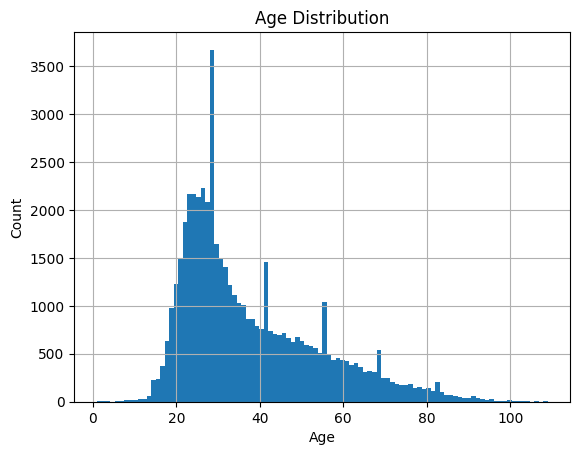

In [9]:
df["age"].hist(bins=100)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")

This plot shows the age distribution after filtering error values. Even now the data shows some suspicious spikes but it is difficult to remove those potential errors due to the volume of those values.

In [10]:
df["gender"].value_counts()

1.0    39842
0.0    12067
Name: gender, dtype: int64

Here, the label 1 refers to males and the 0 refers to females. As we can see we have a class imbalance problem.

## Train Test Split:

For this model, we need to have the same feature data for training across both tasks, becuase if we don't it would result in validation data leaking into the model. Because of the significant class imbalance we will stratify the data across gender. We decided to do an 80/20 split because we feel we have sufficient data with over 50,000 images after filtering.

In [11]:
# sklearn train test split:
from sklearn.model_selection import train_test_split

# same random states so that the same images are in the same sets
X_train, X_test, Y_age_train, Y_age_test = train_test_split(X, Y_age, test_size=0.2, random_state=42, stratify=Y_gender)
_, _, Y_gender_train, Y_gender_test = train_test_split(X, Y_gender, test_size=0.2, random_state=42, stratify=Y_gender)

# Seperate Models

## Gender Classification:

In [12]:
def resnet_block(input, output_filters, strides=1):
    input_filters = input.shape[-1]
    if input_filters != output_filters:
        new_add = tf.keras.layers.Conv2D(output_filters, (1, 1), activation='relu', strides=strides, kernel_regularizer=tf.keras.regularizers.l2(0.001))(input)
    x = tf.keras.layers.Conv2D(output_filters, (3,3), padding="same", strides=strides, kernel_regularizer=tf.keras.regularizers.l2(0.001))(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(output_filters, (3,3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if input_filters != output_filters:
        x = tf.keras.layers.Add()([x, new_add])
    else:
        x = tf.keras.layers.Add()([x, input])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:

strategy = tf.distribute.MirroredStrategy(
    devices=["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3", "/gpu:4", "/gpu:5", "/gpu:6", "/gpu:7"]
)
with strategy.scope():
    input = tf.keras.Input(shape=(256, 256, 3))

    x = tf.keras.layers.Conv2D(16, (7, 7), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input)
    x = tf.keras.layers.BatchNormalization()(x)

    # resnet block
    x = resnet_block(x, 16)
    x = resnet_block(x, 16)
    x = resnet_block(x, 32, 2)
    x = resnet_block(x, 32)
    x = resnet_block(x, 64, 2)
    x = resnet_block(x, 64)

    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    dense = tf.keras.layers.Flatten()(x)
    dense = tf.keras.layers.Dropout(0.3)(dense)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    gender_classification_model = tf.keras.Model(inputs=input, outputs=output)

    gender_classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    gender_classification_model.summary()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task

2023-03-08 23:15:00.820354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 23:15:05.142545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79117 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-03-08 23:15:05.148225: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79117 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-03-08 23:15:05.153874: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/devi

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 250, 250, 16  2368        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 250, 250, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:

history = gender_classification_model.fit(X_train,
        Y_gender_train,
        epochs=25,
        batch_size=64,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)],
        validation_data=(X_test, Y_gender_test))
gender_classification_model.save(PICKLES_PATH + "gender_classification_model.h5")

Epoch 1/25
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1


2023-03-08 23:16:10.684593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 23:16:11.748277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 23:16:12.997964: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 23:16:14.528513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 23:16:16.749655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-08 23:16:20.101130: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7efc04693e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-08 23:16:20.101163: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0

649/649 [==============================] - 88s 86ms/step - loss: 1.2822 - accuracy: 0.7592 - val_loss: 0.7771 - val_accuracy: 0.8070
Epoch 2/25
649/649 [==============================] - 43s 66ms/step - loss: 0.6892 - accuracy: 0.8123 - val_loss: 0.5730 - val_accuracy: 0.8453
Epoch 3/25
649/649 [==============================] - 47s 73ms/step - loss: 0.5273 - accuracy: 0.8407 - val_loss: 0.4824 - val_accuracy: 0.8502
Epoch 4/25
649/649 [==============================] - 43s 67ms/step - loss: 0.4549 - accuracy: 0.8574 - val_loss: 0.4754 - val_accuracy: 0.8401
Epoch 5/25
649/649 [==============================] - 49s 76ms/step - loss: 0.4267 - accuracy: 0.8631 - val_loss: 0.5759 - val_accuracy: 0.7987
Epoch 6/25
649/649 [==============================] - 49s 75ms/step - loss: 0.3895 - accuracy: 0.8721 - val_loss: 0.4857 - val_accuracy: 0.8228
Epoch 7/25
649/649 [==============================] - 47s 73ms/step - loss: 0.4022 - accuracy: 0.8724 - val_loss: 0.4307 - val_accuracy: 0.8538
Epo

Text(0.5, 1.0, 'Loss over epochs')

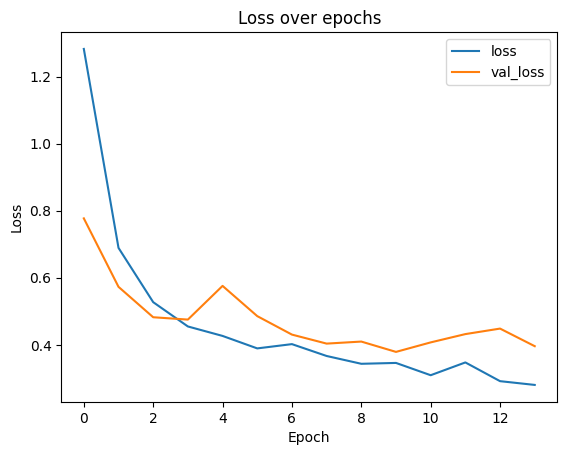

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss over epochs")

The validation loss converges in about 14 epochs. We define convergence as no improvment over 4 epochs.

In [ ]:
gender_classification_model = load_model(PICKLES_PATH + "gender_classification_model.h5")

2023-03-08 11:08:33.714141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 11:08:39.743812: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79117 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-03-08 11:08:39.764422: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79117 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-03-08 11:08:39.776631: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/devi

## Age Regression Model:

In [ ]:
strategy = tf.distribute.MirroredStrategy(
    devices=["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3", "/gpu:4", "/gpu:5", "/gpu:6", "/gpu:7"]
)
with strategy.scope():

    input = tf.keras.Input(shape=(256, 256, 3))

    x = tf.keras.layers.Conv2D(16, (7, 7), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input)
    x = tf.keras.layers.BatchNormalization()(x)

    # resnet block
    x = resnet_block(x, 16)
    x = resnet_block(x, 16)
    x = resnet_block(x, 32, 2)
    x = resnet_block(x, 32)
    x = resnet_block(x, 64, 2)
    x = resnet_block(x, 64)

    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    dense = tf.keras.layers.Flatten()(x)
    dense = tf.keras.layers.Dropout(0.3)(dense)
    output = tf.keras.layers.Dense(1, activation='linear')(dense)

    age_regression_model = tf.keras.Model(inputs=input, outputs=output)

    age_regression_model.compile(optimizer='adam', loss='mse')

    age_regression_model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INF

2023-03-08 22:58:13.236120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 22:58:17.391490: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79117 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-03-08 22:58:17.395399: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79117 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-03-08 22:58:17.399014: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/devi

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                             

In [ ]:
history = age_regression_model.fit(X_train,
        Y_age_train,
        epochs=25,
        batch_size=64,
        validation_data=(X_test, Y_age_test),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)])
age_regression_model.save(PICKLES_PATH + "age_regression_model.h5")

Epoch 1/25
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1


2023-03-08 22:59:38.957140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:59:39.997172: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:59:41.226403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:59:42.892046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:59:44.341097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:59:45.728364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:59:47.125111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:59:48.332212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:59:50.389206: I tensorflow/compiler/xla/st

649/649 [==============================] - 104s 71ms/step - loss: 241.1260 - val_loss: 460.7217
Epoch 2/25
649/649 [==============================] - 29s 45ms/step - loss: 189.2840 - val_loss: 332.9865
Epoch 3/25
649/649 [==============================] - 29s 45ms/step - loss: 169.0851 - val_loss: 179.4767
Epoch 4/25
649/649 [==============================] - 29s 44ms/step - loss: 156.1411 - val_loss: 191.0158
Epoch 5/25
649/649 [==============================] - 30s 45ms/step - loss: 148.0820 - val_loss: 153.7239
Epoch 6/25
649/649 [==============================] - 31s 47ms/step - loss: 137.8512 - val_loss: 188.7496
Epoch 7/25
649/649 [==============================] - 33s 51ms/step - loss: 131.5545 - val_loss: 170.7551
Epoch 8/25
649/649 [==============================] - 31s 47ms/step - loss: 124.6967 - val_loss: 150.6117
Epoch 9/25
649/649 [==============================] - 34s 52ms/step - loss: 118.3035 - val_loss: 167.5344
Epoch 10/25
649/649 [==============================] - 3

Text(0.5, 1.0, 'Loss over epochs')

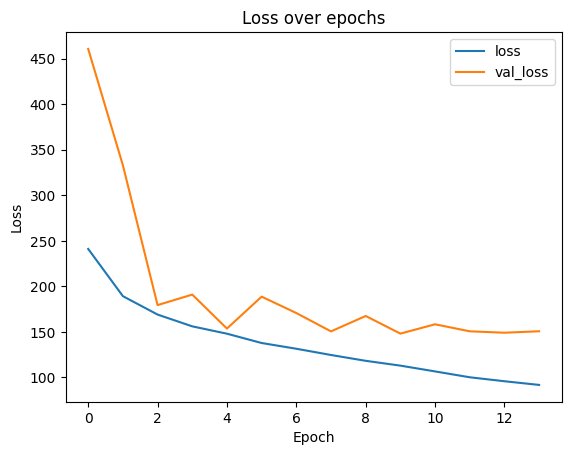

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss over epochs")

## Multi Task Model:

In [ ]:
strategy = tf.distribute.MirroredStrategy(
    devices=["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3", "/gpu:4", "/gpu:5", "/gpu:6", "/gpu:7"]
)

with strategy.scope():

    input = tf.keras.Input(shape=(256, 256, 3))

    x = tf.keras.layers.Conv2D(16, (7, 7), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input)
    x = tf.keras.layers.BatchNormalization()(x)

    # resnet block
    x = resnet_block(x, 16)
    x = resnet_block(x, 16)
    x = resnet_block(x, 32, 2)
    x = resnet_block(x, 32)
    x = resnet_block(x, 64, 2)
    x = resnet_block(x, 64)

    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    dense = tf.keras.layers.Flatten()(x)
    dense = tf.keras.layers.Dropout(0.5)(dense)

    age_dense = tf.keras.layers.Dense(1, activation='linear')(dense)
    gender_dense = tf.keras.layers.Dense(1, activation='sigmoid', )(dense)

    multi_task_model = Model(inputs=[input], outputs=[age_dense, gender_dense])

    multi_task_model.compile(optimizer='adam', loss=['mse', 'binary_crossentropy'], loss_weights=[0.003, 0.997])

    multi_task_model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2023-03-08 22:46:23.876370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 22:46:28.029394: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79117 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-03-08 22:46:28.033229: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79117 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-03-08 22:46:28.036820: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/devi

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [ ]:
history = multi_task_model.fit(X_train,
        [Y_age_train, Y_gender_train],
        epochs=25,
        validation_data=(X_test, [Y_age_test, Y_gender_test]),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)],
        batch_size=64)
multi_task_model.save(PICKLES_PATH + "multi_task_model.h5")

Epoch 1/25
INFO:tensorflow:batch_all_reduce: 60 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 60 all-reduces with algorithm = nccl, num_packs = 1


2023-03-08 22:47:56.970162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:47:58.081353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:47:59.326546: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:48:00.947826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:48:02.363153: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:48:03.785330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:48:05.218432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:48:06.628340: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-08 22:48:09.597975: I tensorflow/compiler/xla/st

649/649 [==============================] - 117s 83ms/step - loss: 1.8198 - dense_loss: 284.9066 - dense_1_loss: 0.8444 - val_loss: 1.2001 - val_dense_loss: 229.0342 - val_dense_1_loss: 0.4248
Epoch 2/25
649/649 [==============================] - 35s 54ms/step - loss: 1.1775 - dense_loss: 215.8962 - dense_1_loss: 0.4928 - val_loss: 1.0403 - val_dense_loss: 211.2932 - val_dense_1_loss: 0.4187
Epoch 3/25
649/649 [==============================] - 33s 50ms/step - loss: 0.9492 - dense_loss: 194.1459 - dense_1_loss: 0.3983 - val_loss: 0.8725 - val_dense_loss: 194.6790 - val_dense_1_loss: 0.3496
Epoch 4/25
649/649 [==============================] - 33s 51ms/step - loss: 0.8516 - dense_loss: 184.5024 - dense_1_loss: 0.3666 - val_loss: 0.8945 - val_dense_loss: 193.6483 - val_dense_1_loss: 0.4047
Epoch 5/25
649/649 [==============================] - 34s 53ms/step - loss: 0.7999 - dense_loss: 178.0267 - dense_1_loss: 0.3492 - val_loss: 0.7875 - val_dense_loss: 185.0467 - val_dense_1_loss: 0.3291


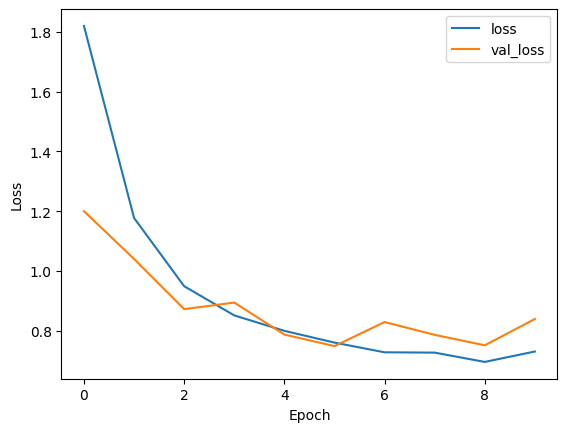

In [ ]:
# plot history:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [13]:
multi_task_model = load_model(PICKLES_PATH + "multi_task_model.h5")

2023-03-08 23:56:45.688361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 23:56:49.811236: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79117 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-03-08 23:56:49.815091: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79117 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-03-08 23:56:49.818728: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/devi

In [15]:
# keras augmentation function:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)

In [16]:
def data_generator(batch_size=32):
    X_batch, Y_age_batch, Y_gender_batch = [], [], []
    curr_index = 0
    while True:
        if curr_index + batch_size > len(X_train):
            curr_index = 0
        X_batch = X_train[curr_index:curr_index+batch_size]
        Y_age_batch = Y_age_train[curr_index:curr_index+batch_size]
        Y_gender_batch = Y_gender_train[curr_index:curr_index+batch_size]

        # copy and pasting Y_age_batch onto itself because that will be the same for the second output
        Y_age_batch = np.concatenate((Y_age_batch, Y_age_batch), axis=0)
        Y_gender_batch = np.concatenate((Y_gender_batch, Y_gender_batch), axis=0)

        X_aug = datagen.flow(X_batch, batch_size=batch_size, shuffle=False).next()
        X_batch = np.concatenate((X_batch, X_aug), axis=0)

        curr_index += batch_size

        yield X_batch, [Y_age_batch, Y_gender_batch]

## Consistency Loss

In [55]:
# fine tune multi_task_model with consistency loss
'''

Consisitency loss is a loss function that is used to train a model to be consistent when augmented forms of the same image are fed 
to the model. 
This is done by training the model to minimize the difference between the predictions of the original image and the augmented image.

We will need to feed forward the originial image, then feed forward the augmented image, and then calculate the loss between the two predictions.
'''

def consistency_loss(y_true, y_pred):

    # print(y_true[0])
    # print(y_true[1])

    y_true_age = y_true[0]
    y_true_gender = y_true[1]
    y_pred_age = y_pred[0]
    y_pred_gender = y_pred[1]

    print(y_true_age.get_shape())

    length = len(y_true_age)
    y_pred_norm = y_pred_gender[:length//2]
    y_pred_aug = y_pred_gender[length//2:]
    y_true_norm = y_true_gender[:length/2]

    return tf.keras.losses.binary_crossentropy(y_true_gender, y_pred_gender) + tf.keras.losses.MeanSquaredError(y_true_age, y_pred_age) + tf.keras.losses.binary_crossentropy(y_pred_norm, y_pred_aug)


input = tf.keras.Input(shape=(256, 256, 3))

x = tf.keras.layers.Conv2D(16, (7, 7), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input)
x = tf.keras.layers.BatchNormalization()(x)

# resnet block
x = resnet_block(x, 16)
x = resnet_block(x, 16)
x = resnet_block(x, 32, 2)
x = resnet_block(x, 32)
x = resnet_block(x, 64, 2)
x = resnet_block(x, 64)

x = tf.keras.layers.MaxPooling2D((2, 2))(x)
dense = tf.keras.layers.Flatten()(x)
dense = tf.keras.layers.Dropout(0.5)(dense)

age_dense = tf.keras.layers.Dense(1, activation='linear')(dense)
gender_dense = tf.keras.layers.Dense(1, activation='sigmoid', )(dense)

multi_task_model = Model(inputs=[input], outputs=[age_dense, gender_dense])

multi_task_model.compile(optimizer='adam', loss=[consistency_loss ])

multi_task_model.summary()



Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_285 (Conv2D)            (None, 250, 250, 16  2368        ['input_20[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_247 (Batch  (None, 250, 250, 16  64         ['conv2d_285[0][0]']             
 Normalization)                 )                                                          

In [56]:
multi_task_model.fit_generator(data_generator(batch_size=32), epochs=25)

/tmp/ipykernel_1935952/1200628781.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  multi_task_model.fit_generator(data_generator(batch_size=32), epochs=25)


Epoch 1/25
(1,)


TypeError: in user code:

    File "/users/skoka/.venv/tensorflow/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/tmp/ipykernel_1935952/1676031938.py", line 26, in consistency_loss  *
        y_true_norm = y_true_gender[:length/2]

    TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got 0.5
